In [1]:
options(tidyverse.quiet = TRUE) 
library(tidyverse, warn.conflicts = FALSE)

library(badr)
load_julia_package()

Loaded julia package 'bad' successfully.



# Finding Optimal Two-Stage Designs

## Optimisation under uncertainty

### Prior choice

Start by defining the standard parameters.

In [2]:
alpha <- .05
beta  <- .2
p0    <- .2
p1    <- .4

Define uniform prior (maximum entropy, Beta(1,1)), then the subjective prior and update it with 4/10 out of assumed pilot trial. Finally robustify the informative prior with the maximum entropy one.

In [3]:
# non-informative component
noninformative        <- Beta(1, 1)
# informative prior component
informative           <- Beta_mu_sd(.35, .1)
# update with pilot data
informative_plus_data <- update(informative, 4, 10)
# combine with non-informative and cap upper tail
pragmatic             <- (0.2*noninformative + 0.8*informative_plus_data) <= 0.7

In [4]:
tbl_priors <- tibble(
        p                 = seq(0, 1, .001),
        informative = density(informative, p),
        `informative + data` = density(informative_plus_data, p),
        pragmatic         = density(pragmatic, p)
    ) %>%
    mutate(
        pragmatic = ifelse(abs(p - 0.7) == min(abs(p - 0.7)), NA_real_, pragmatic)
    ) %>%
    pivot_longer(-p, names_to = 'prior') %>%
    mutate(
        prior = factor(prior, levels = c(
                "informative",  "informative + data", "pragmatic"
            )
        )
    )

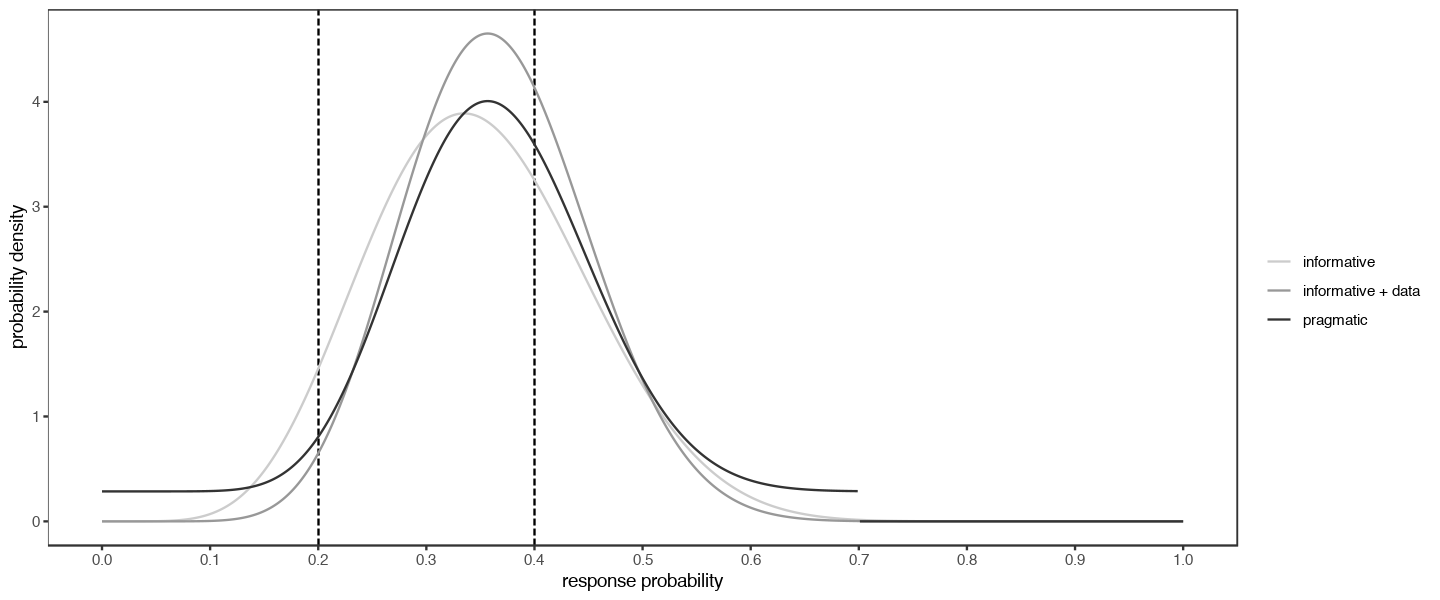

In [5]:
# plot
options(repr.plot.width = 12, repr.plot.height = 5)

ggplot(tbl_priors) +
    aes(p, value) +
    geom_vline(xintercept = c(p0, p1), color = 'black', linetype = 'longdash') +
    geom_line(aes(color = prior)) +
    scale_color_grey('', start = .8, end = .2) +
    scale_x_continuous('response probability', breaks = seq(0, 1, .1)) +
    scale_y_continuous('probability density') +
    theme_bw() +
    theme(
        panel.grid = element_blank()
    )


In [6]:
ggsave("optimisation-under-uncertainty-prior-choice.pdf", width = 7, height = 3)

In [7]:
design_uniform <- Problem(
        minimise(SampleSize(noninformative)),
        Power(noninformative %|% p0) <= alpha,
        Power(noninformative %|% p1) >= 1 - beta,
        label = 'non-informative'
    ) %>%
    optimise_design()

design_pragmatic <- Problem(
        minimise(SampleSize(pragmatic)),
        Power(noninformative %|% p0) <= alpha,
        Power(noninformative %|% p1) >= 1 - beta,
        label = 'pragmatic'
    ) %>%
    optimise_design()

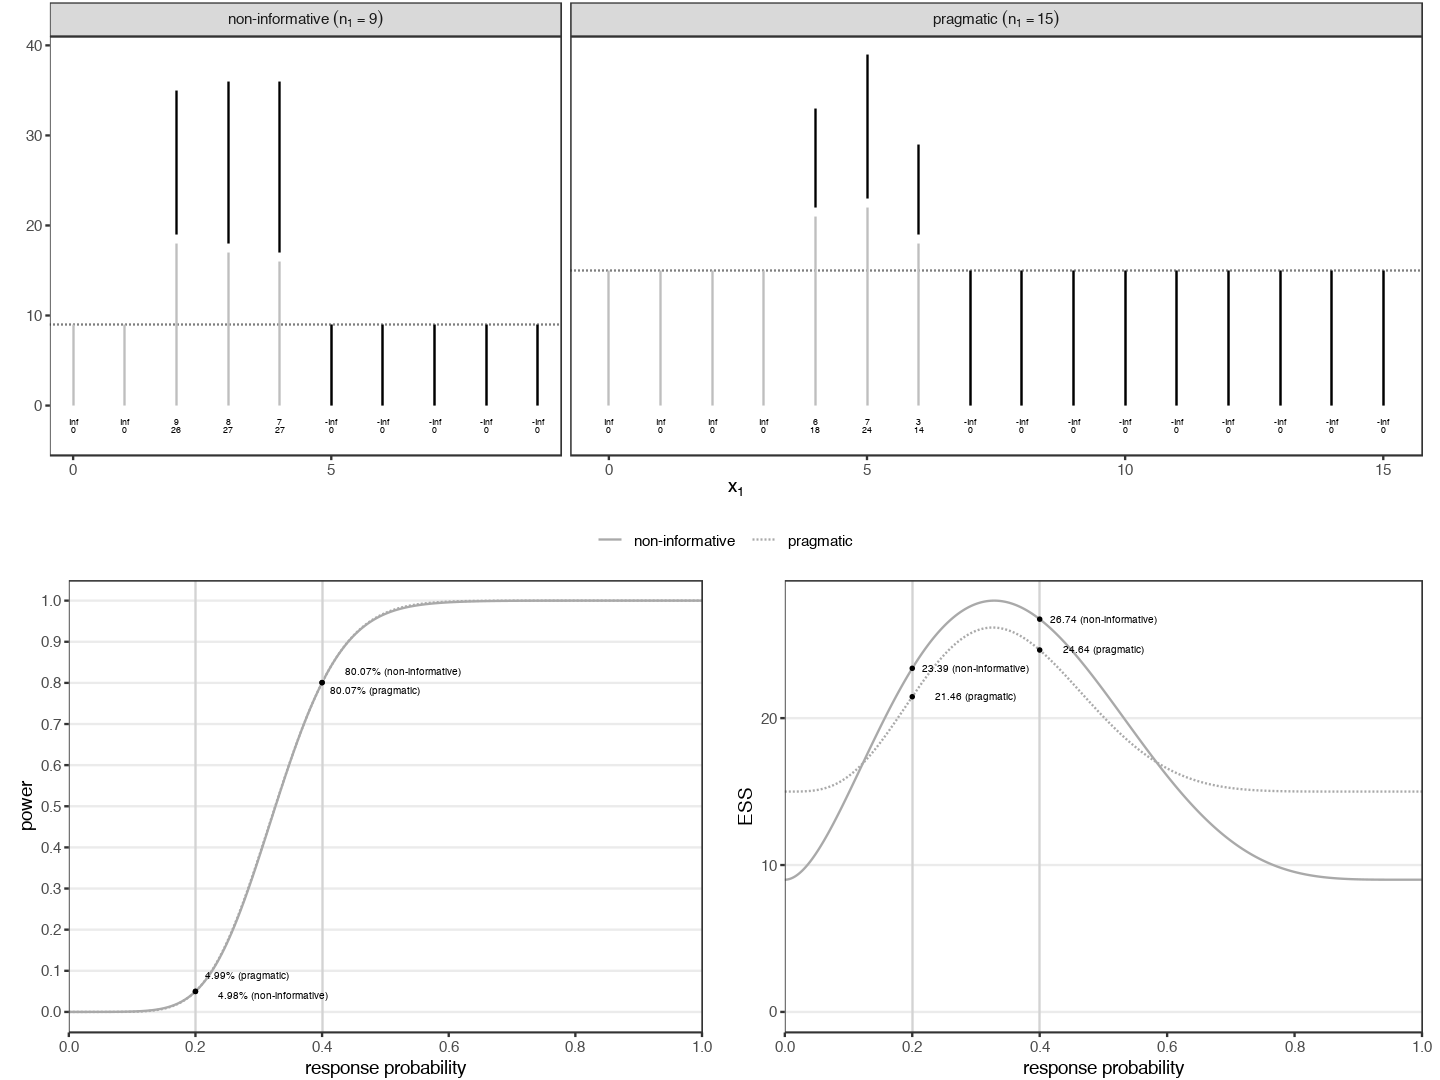

In [8]:
# plot
options(repr.plot.width = 12, repr.plot.height = 9)

plot_compare_designs(
    design_uniform, design_pragmatic,
    annotations = c(p0, p1)
)

In [9]:
ggsave("optimisation-under-uncertainty-prior-choice-designs.pdf", width = 7, height = 7)

### Power constraints

First, the minimal clinically relevant value for the response probability is defined before comparing the desings minimising expected sample size under the quantile approach, the point alternative and the expected power approach.

In [4]:
mcr <- 0.3

In [11]:
p        <- seq(0, 1, .01)
quantile <- function(prior, prob) {
    uniroot(
        function(p) cdf(prior, p) - prob, 
        interval = c(.01, .99), 
        tol = sqrt(.Machine$double.eps)
    )$root
}

In [12]:
design_p1 <- Problem(
        minimise( SampleSize(pragmatic) ),
        Power(noninformative %|% p0) <= alpha,
        Power(noninformative %|% p1) >= 1 - beta,
        label = 'p = 0.4'
    ) %>%
    optimise_design()

In [13]:
design_ep <- Problem(
        minimise( SampleSize(pragmatic) ),
        Power(noninformative %|% p0)  <= alpha,
        Power(pragmatic >= mcr) >= 1 - beta,
        label = 'EP'
    ) %>%
    optimise_design()

In [14]:
design_quantile <- Problem(
        minimise( SampleSize(pragmatic) ),
        Power(noninformative %|% p0)  <= alpha,
        Power(noninformative %|% quantile(pragmatic >= mcr, .33)) >= 1 - beta,
        label = 'quantile'
    ) %>%
    optimise_design()

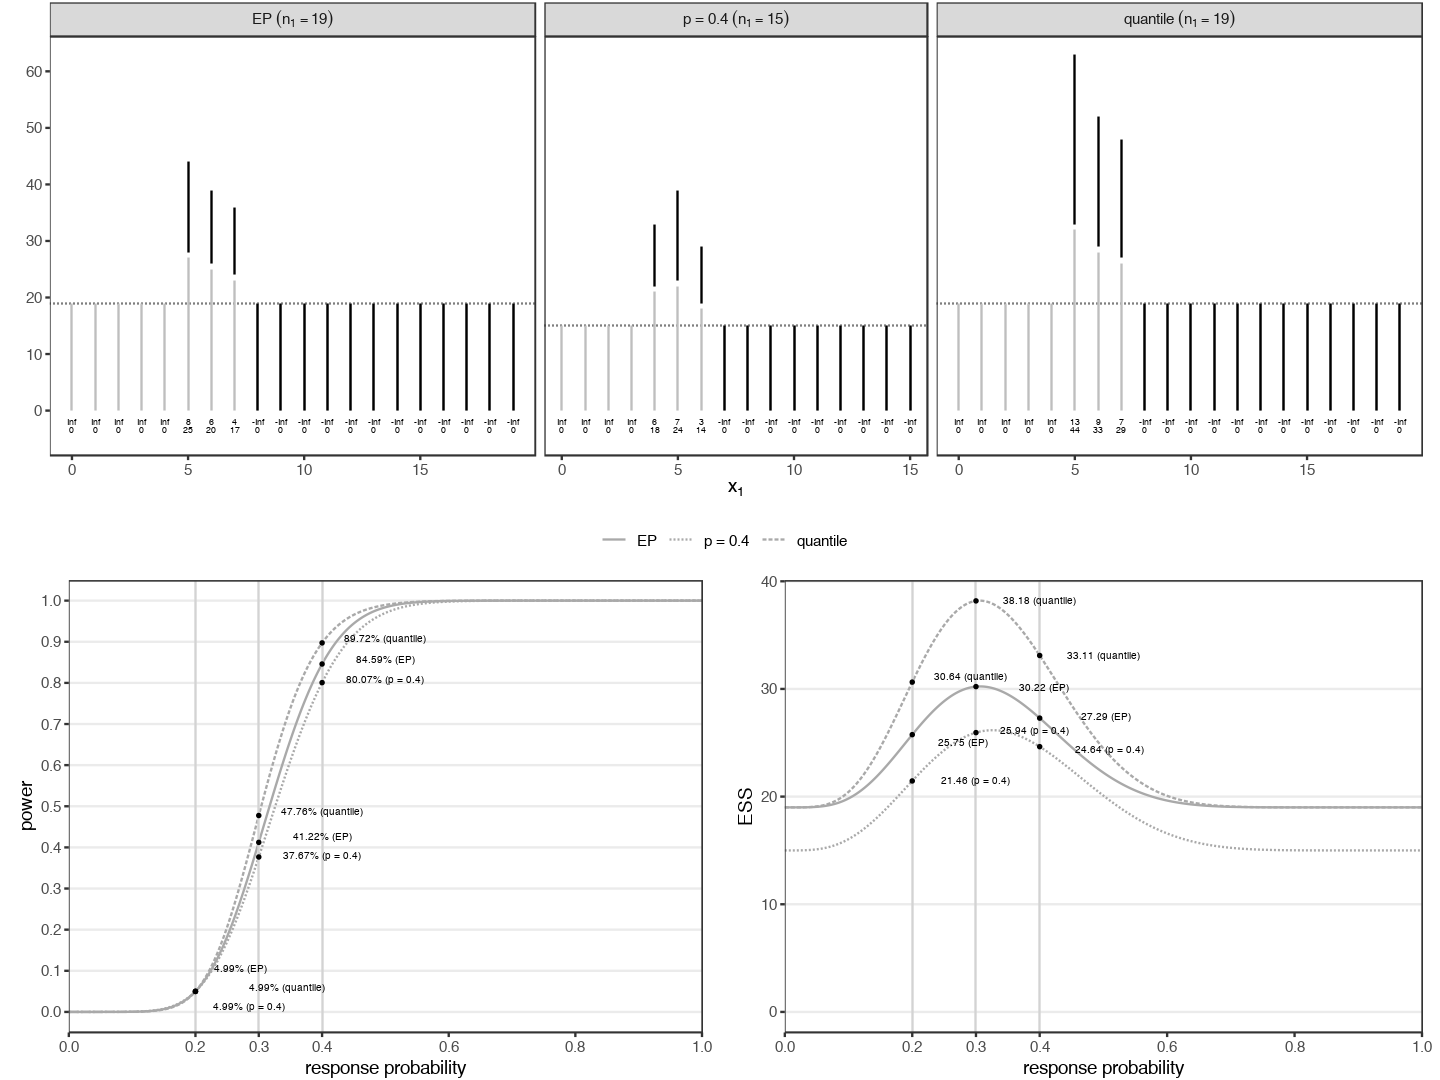

In [15]:
# plot
options(repr.plot.width = 12, repr.plot.height = 9)

plot_compare_designs(
    design_p1, design_ep, design_quantile,
    annotations = c(p0, mcr, p1)
)

In [23]:
ggsave("optimisation-under-uncertainty-power-constraints.pdf", width = 7, height = 7)

### Power at MRV under Expected Power for varying priors

Here, the influence of the informative prior component of the resulting design is investgated by varying the initial prior standard deviation and mean.

In [ ]:
tbl_designs <- expand_grid(
        mu = seq(.1, .8, by = .05),
        sd = seq(.05, .25, by = .05)
    ) %>%
    mutate(
        prior = map2(mu, sd, function(mu, sd) {
            (0.2*Beta(1,1) + 0.8*update(Beta_mu_sd(mu, sd), 4, 10)) <= 0.7
        }),
        a = map_dbl(prior, ~JuliaCall::field(JuliaCall::field(.@jprior, "priors")[2], "a")),
        b = map_dbl(prior, ~JuliaCall::field(JuliaCall::field(.@jprior, "priors")[2], "b")),
        design = map(prior, function(prior) {
            print(prior)
            Problem(
                minimise(SampleSize(prior)),
                Power(prior %|% p0)  <= alpha,
                Power(prior >= mcr) >= 1 - beta
            ) %>%
            optimise_design()
        })
    )

print(tbl_designs, n = 10)

In [ ]:
# plot
options(repr.plot.width = 12, repr.plot.height = 5)

tbl_designs %>%
    mutate(
        data = map(design, function(design) {
            tibble(
                power = probability_to_reject(design, mcr)
            )
        })
    ) %>%
    unnest(data) %>%
    ggplot(aes(mu, sd)) +
    geom_raster(aes(fill = power)) +
    scale_fill_gradient(low = 'white', high = 'black', limits = c(0, 1)) +
    coord_cartesian(expand = FALSE) +
    labs(x = 'informative prior mean', y = 'informative prior standard deviation') +
    theme_bw() +
    theme(
        legend.position = 'right'
    )

In [ ]:
ggsave("optimisation-under-uncertainty-power-vs-prior-parameters.pdf", width = 7, height = 3)

### Utility based approach

Start by defining the individual components of the utility score.

In [5]:
# expected sample size
ess   <- SampleSize(pragmatic)

# maximal type one error rate
mtoer <- Power(pragmatic %|% p0)
# expected type one error rate
etoer <- Power(pragmatic <= mcr)
# expected power
epow  <- Power(pragmatic >= mcr)

# probability of success
pos   <- (1 - cdf(pragmatic, mcr)) * epow
# probability of a type one error
potoe <- cdf(pragmatic, p0) * etoer

In [6]:
# resolve for optimal design under pragmatic prior for expected power constraint
design_initial <- Problem(
        minimise(ess),
        (mtoer <= alpha) %>% conditional(c(.001, .5)),   # impose additional conditional error rate constraints
                                                         # to make optimisation faster
        (epow  >= 1 - beta) %>% conditional(c(.5, .999)),
        label = 'initial design'
    ) %>%
    optimise_design()

Make sure that the new formulation results in the same design

In [7]:
# plot
options(repr.plot.width = 12, repr.plot.height = 9)

plot_compare_designs(
    design_ep, design_initial
)

ERROR: Error in plot_compare_designs(design_ep, design_initial): object 'design_ep' not found


In [8]:
# define function to find utility-maximising design given $\lambda=(\lambda_{+,+},\lambda{+,-})$
f <- function(lambda) Problem(
        maximise(lambda[1]*pos - lambda[2]*potoe - ess),
        (mtoer <= 4*alpha)    %>% conditional(c(.001, .5)),    # relax type one error rate constraintr
        (epow  >= 1 - 2*beta) %>% conditional(c(.5, .999)),    # relax power constraint
        n1values = 10:30,    # make sure that the search space is still large enough even though the 
                             # constraints are so liberal
        nmax     = 70
    ) %>%
    optimise_design()

In [9]:
# define function to measure the maximal difference in power between two designs
delta <- function(design1, design2) {
    p <- seq(0, 1, .01)
    return( 100 * max( abs(
        probability_to_reject(design1, p) - probability_to_reject(design2, p)
    ) ) )
}

In [10]:
# evaluate the difference from the initial design on a grid of lambda values
# exploit the fact the we know the rough relative size of lambda++ and lambda+- from \alpha and \beta
tbl_grid <- expand_grid(
        w   = seq(.05, .15, length.out = 5),
        fct = seq(1000, 3000, length.out = 15)
    ) %>%
    mutate(
        lambda_tp      = w * fct,
        lambda_fp      = (1 - w) * fct,
        optimal_design = map2(lambda_tp, lambda_fp, ~f(c(.x, .y))),
        delta          = map_dbl(optimal_design, ~delta(., design_initial))
    )

print(tbl_grid, n = 10)

# A tibble: 75 x 6
       w   fct lambda_tp lambda_fp optimal_design delta
   <dbl> <dbl>     <dbl>     <dbl> <list>         <dbl>
 1  0.05 1000       50        950  <Design>        24.3
 2  0.05 1143.      57.1     1086. <Design>        25.8
 3  0.05 1286.      64.3     1221. <Design>        25.8
 4  0.05 1429.      71.4     1357. <Design>        25.8
 5  0.05 1571.      78.6     1493. <Design>        24.4
 6  0.05 1714.      85.7     1629. <Design>        24.2
 7  0.05 1857.      92.9     1764. <Design>        24.2
 8  0.05 2000      100       1900  <Design>        24.2
 9  0.05 2143.     107.      2036. <Design>        24.6
10  0.05 2286.     114.      2171. <Design>        24.6
# … with 65 more rows


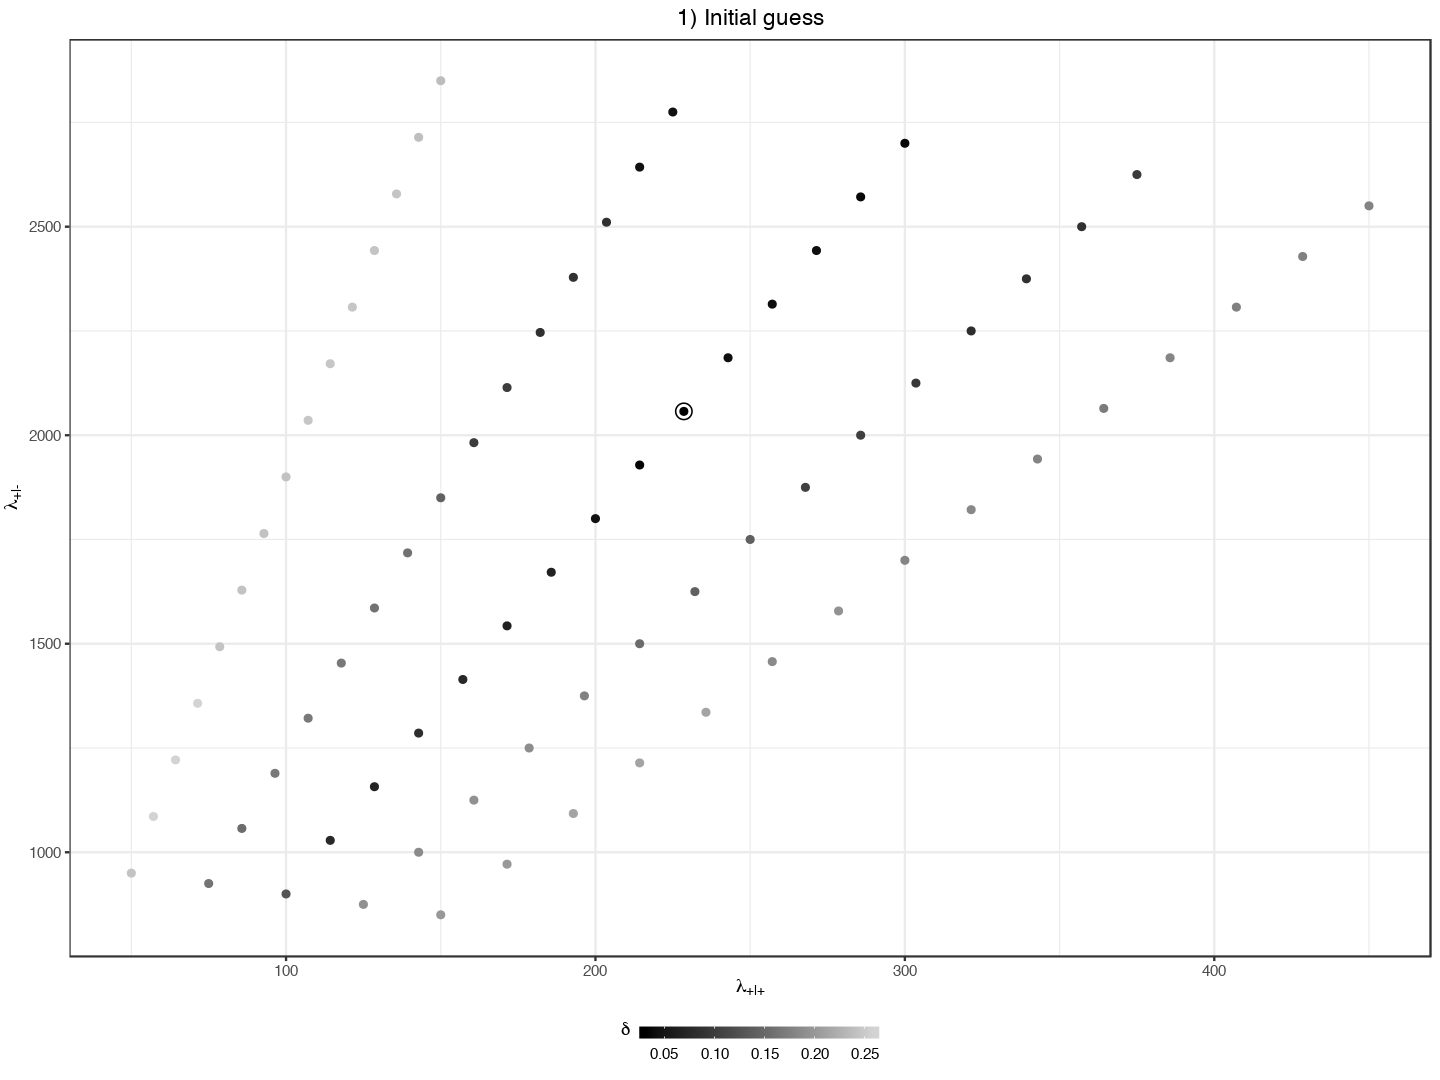

In [11]:
# plot
options(repr.plot.width = 12, repr.plot.height = 9)

plot_initial_guess <- ggplot(tbl_grid) +
    aes(lambda_tp, lambda_fp) +
    geom_point(shape = 1, size = 4, data = filter(tbl_grid, delta == min(delta))) +
    geom_point(aes(color = delta/100)) +
    scale_color_gradient(expression(delta), low = 'black', high = 'lightgray') +
    scale_x_continuous(expression(lambda['+|+'])) +
    scale_y_continuous(expression(lambda['+|-'])) +
    ggtitle('1) Initial guess', ) +
    theme_bw() +
    theme(
        plot.title   = element_text(hjust = .5, face = 'bold'),
        legend.title = element_text(vjust = 1),
        legend.position = 'bottom',
        legend.key.width = unit(2, 'lines'),
        legend.key.height = unit(.5, 'lines')
    )

plot_initial_guess

Refine the search by a local Nelder-Mead optimisation around the best combination of $\lambda$ found on the grid. 
Nelder-Mead is sensitive to scaling, so one needs to guess the problem scale first (difference in marginal paramters corresponding to unit change in objective).

Clealry, a parametrisation in term of the ratio of the two parameters is sensible.

In [12]:
filter(tbl_grid, delta == min(delta)) %>% select(-optimal_design)

w,fct,lambda_tp,lambda_fp,delta
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1,2285.714,228.5714,2057.143,3.088164


In [13]:
initial_values <- filter(tbl_grid, delta == min(delta)) %>%
    {c(.$lambda_tp, .$lambda_fp)}

initial_values_ratio <- filter(tbl_grid, delta == min(delta)) %>%
    {c(.$w, .$fct)}

design_init <- f(initial_values)

In [14]:
# convert between ration and absolute values
reparametrise <- function(x) {
    c(
        lambda_tp = x[1] * x[2],
        lambda_fp = (1 - x[1]) * x[2]
    )
}

# difference in objective from initial design for given lambda + (a, b), lambda - (a, b) averaged
# to guess scale for Nelder-Mead
diff <- function(dration, dmagnitude) {
    (delta(design_init, f(reparametrise(initial_values_ratio + c(dration, dmagnitude)))) + 
     delta(design_init, f(reparametrise(initial_values_ratio - c(dration, dmagnitude))))
    )/2
}

In [15]:
# aim for a diff of 5 and scale objective
# could use uniroot, this is just refined guessing
diff(.015, 0)

[1] 5.064505

In [16]:
diff(0, 900)

[1] 4.763829

In [17]:
parscale <- c(.015, 900)

Set everything up for Nelder-Mead and saving the optimisation trace.

In [18]:
# this is the table to save the optimisation trace to
tbl_opt_trace <- tibble(
    i         = integer(0),
    lambda_tp = numeric(0),
    lambda_fp = numeric(0),
    delta     = numeric(0)
)

# the counter keeps track of function invocations of the optimiser
counter <- function() {
    i <- 1
    function() {
        res <- i
        i <<- i + 1
        return(res)
    }
}
cntr <- counter()

# wrap the delta function such that the counter is updated each call and the 
# parameter configuration is stored in the trace table
h <- function(x) {
    lambda <- reparametrise(x)
    step   <- tibble(
        i         = cntr(),
        lambda_tp = lambda[1],
        lambda_fp = lambda[2],
        delta     = delta(design_initial, f(lambda))
    )
    tbl_opt_trace <<- bind_rows(tbl_opt_trace, step)
    return(step$delta)
}

In [19]:
# run the actual optimisation
res <- optim(
    initial_values_ratio,
    h,
    control = list(
        trace    = 10,
        parscale = parscale, # parameter scale determined earlier
        fnscale  = 5, # adjust objective scaling to parameter scaling 
        abstol   = .000001,
        reltol   = 0.,
        maxit    = 50,
        REPORT   = 1
    )
)

  Nelder-Mead direct search function minimizer
function value for initial parameters = 0.617633
  Scaled convergence tolerance is 0
Stepsize computed as 0.666667
BUILD              3 1.442605 0.617633
REFLECTION         5 0.725820 0.428327
REFLECTION         7 0.617633 0.324088
HI-REDUCTION       9 0.428327 0.093538
HI-REDUCTION      11 0.324088 0.093538
LO-REDUCTION      13 0.215704 0.090483
REFLECTION        15 0.093538 0.083105
HI-REDUCTION      17 0.090483 0.083105
Exiting from Nelder Mead minimizer
    19 function evaluations used


ERROR: Error in reparamtrise(res$par): could not find function "reparamtrise"


In [21]:
optimal_lambda <- reparametrise(res$par)

optimal_lambda

lambda_tp lambda_fp 
 242.5342 2221.3051

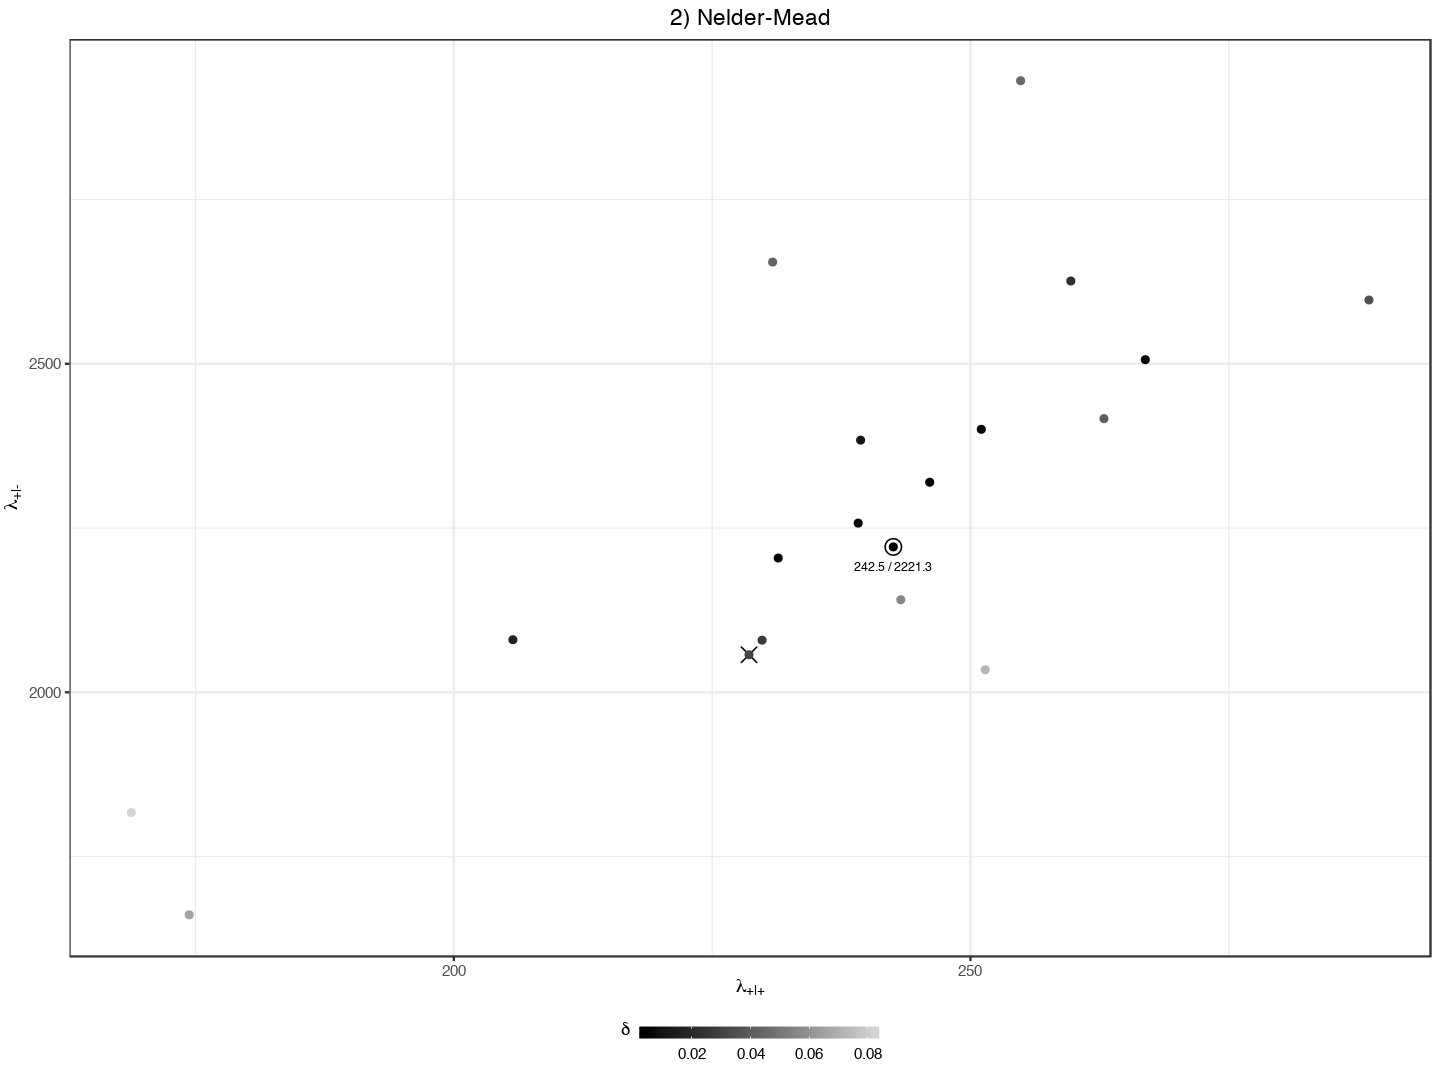

In [42]:
# plot
options(repr.plot.width = 12, repr.plot.height = 9)

plot_nelder_mead <- ggplot(tbl_opt_trace) +
    aes(lambda_tp, lambda_fp) +
    geom_point(shape = 4, size = 4, data = filter(tbl_grid, delta == min(delta))) +
    geom_point(shape = 1, size = 4, data = tibble(
            lambda_tp = optimal_lambda[1], 
            lambda_fp = optimal_lambda[2], 
            delta = res$value
        )
    ) +
    geom_point(aes(color = delta/100)) +
    geom_text(aes(label = label), size = 2.5, data = tibble(
            lambda_tp = optimal_lambda[1],
            lambda_fp = optimal_lambda[2] - 30,
            label     = sprintf("%.1f / %.1f", optimal_lambda[1], optimal_lambda[2])
        )
    ) +
    scale_color_gradient(expression(delta), low = 'black', high = 'lightgray') +
    scale_x_continuous(expression(lambda['+|+'])) +
    scale_y_continuous(expression(lambda['+|-'])) +
    ggtitle('2) Nelder-Mead', ) +
    theme_bw() +
    theme(
        plot.title      = element_text(hjust = .5, face = 'bold'),
        legend.title    = element_text(vjust = 1),
        legend.position = 'bottom',
        legend.key.width = unit(2, 'lines'),
        legend.key.height = unit(.5, 'lines')
    )

plot_nelder_mead

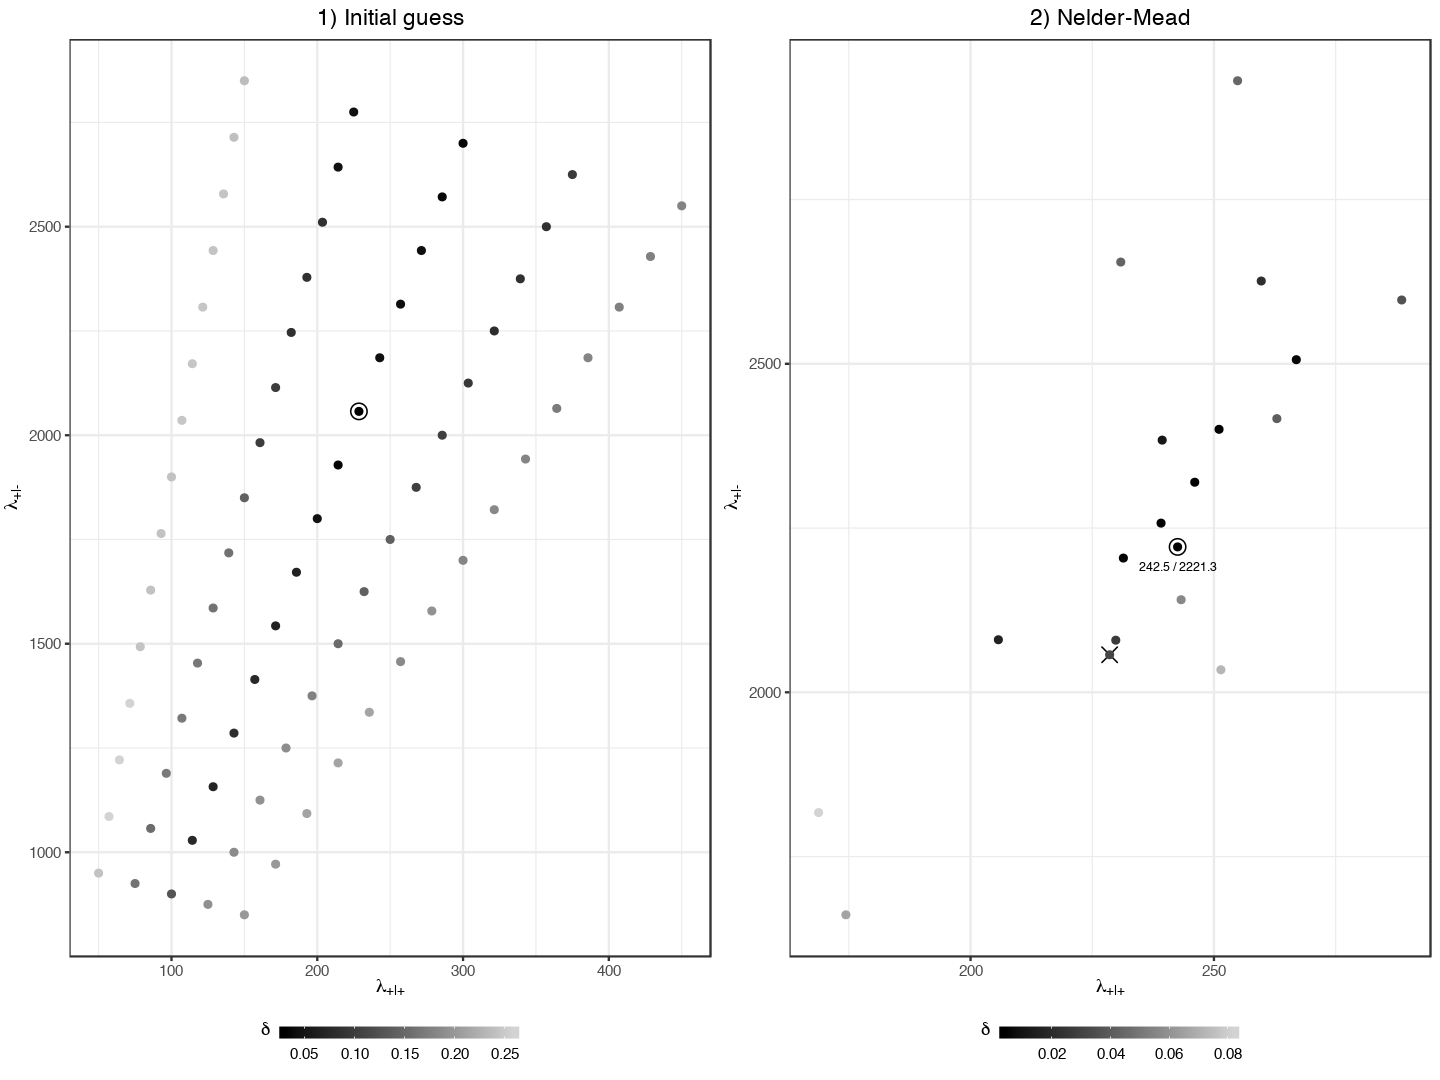

In [43]:
# combine both plots
options(repr.plot.width = 12, repr.plot.height = 9)

cowplot::plot_grid(plot_initial_guess, plot_nelder_mead)

In [24]:
ggsave("optimisation-under-uncertainty-matched-utility-trace.pdf", width = 7, height = 3.5)

In [25]:
design_matched       <- f(reparametrise(res$par))
design_matched@label <- 'matched utility'

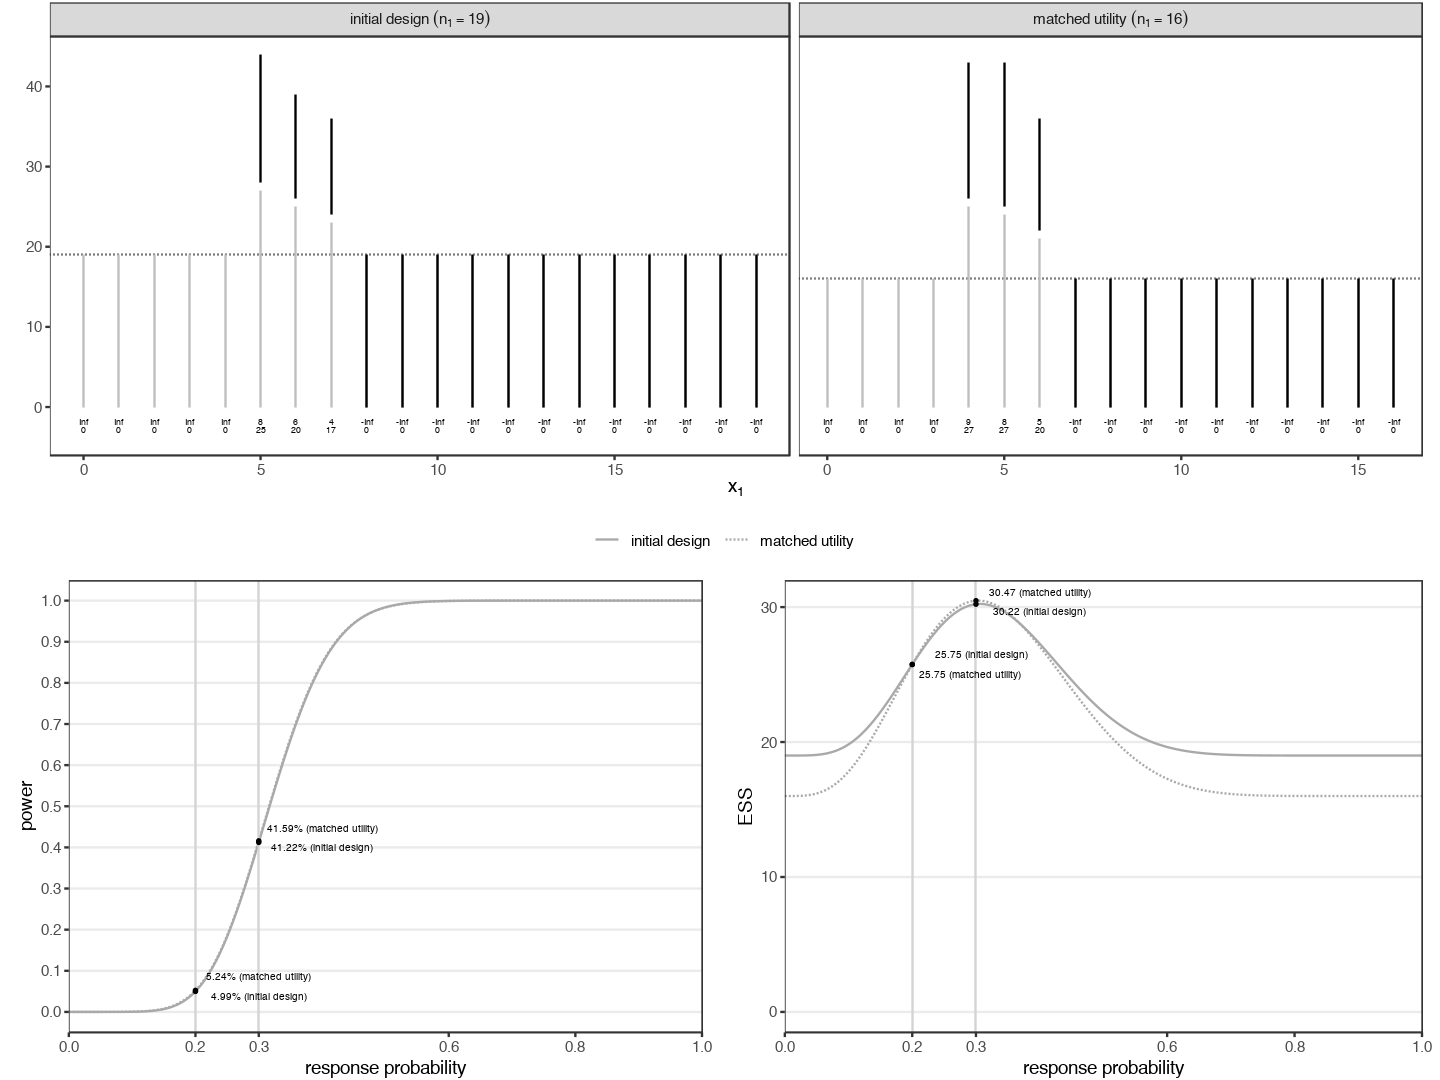

In [26]:
plot_compare_designs(
    design_initial, design_matched,
    annotations = c(p0, mcr)
)

In [27]:
ggsave("optimisation-under-uncertainty-matched-utility-design.pdf", width = 7, height = 7)

In [29]:
utility <- optimal_lambda[1]*pos - optimal_lambda[2]*potoe - ess

evaluate(utility, design_initial)
evaluate(utility, design_matched)

[1] 84.35406

[1] 84.725

In [38]:
evaluate(optimal_lambda[1]*pos, design_initial)
evaluate(optimal_lambda[2]*potoe, design_initial)
evaluate(ess, design_initial)

[1] 142.3423

[1] 31.30801

[1] 26.68024

In [31]:
design_case_a <- f(c(333, optimal_lambda[2]))
design_case_a@label <- 'A'

design_case_b <- f(c(optimal_lambda[1], 1500))
design_case_b@label <- 'B'

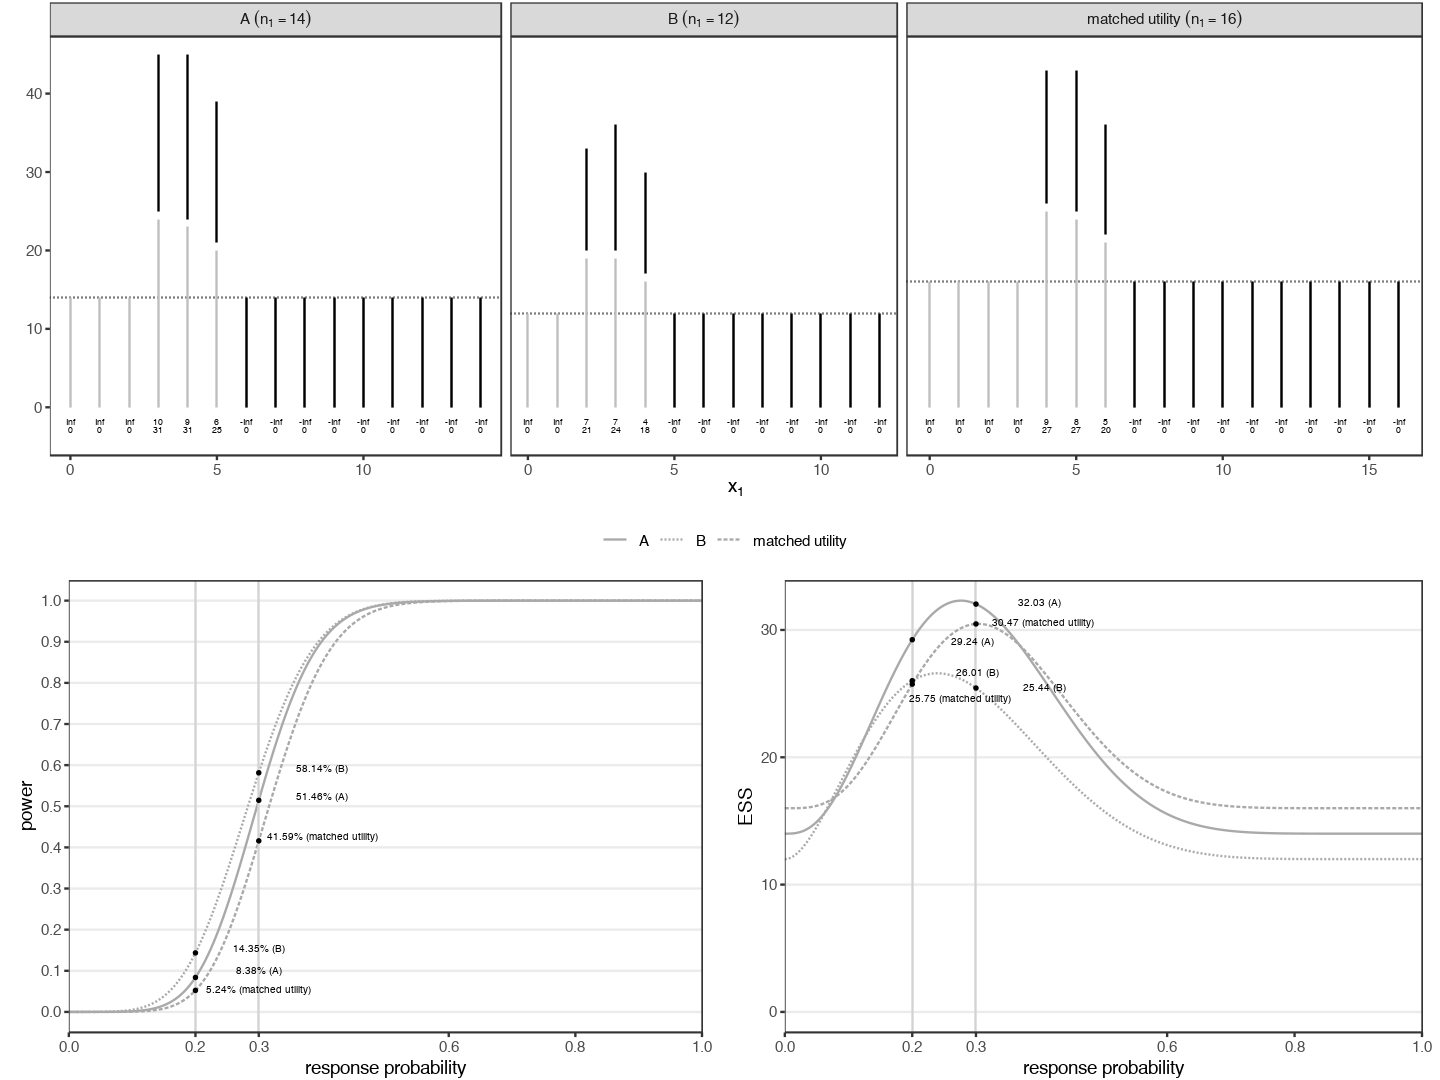

In [32]:
plot_compare_designs(
    design_matched, design_case_a, design_case_b,
    annotations = c(p0, mcr)
)

In [ ]:
ggsave("optimisation-under-uncertainty-matched-utility-cases.pdf", width = 7, height = 7)